### Getting started

In [1]:
import warnings

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

###
from jie import plot
from jie import aligner

###
# Multiprocessing
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool

# from https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm
# Author: Darkonaut (08/05/2019)

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap

### Setting up
- The rationale and documentation for the next few steps are discussed in `jie/jupyter/03-seqFISH-plus-mouse-brain-spatial-genome-alignment`. 
1. __Download data__
2. __Reference Genome__
3. __Candidate spatial coordinates__

- After step 3, we can reorganize the spatial coordinates by cell.
- Distance parameters used for the manuscript is provided under `jie/data/params`


#### 1. Download data

In [2]:
%%bash
dir='../data/mbrain'
if [[ ! -e $dir ]]; then
    mkdir ../data/mbrain
    wget -i ../data/mbrain_seqfish_urls.txt -P ../data/mbrain
fi

#### 2. Reference genome

In [3]:
df = pd.read_csv("../data/TableS0_Mbcoords.csv")

# find genomic distance between each bin 
df_list = []

# for every chromosome
for chrom, group in df.groupby('Chrom'):
    
    # find genomic distance relative to preceding bin
    _df = copy.deepcopy(group)
    
    # sort by start
    _df.sort_values(by='Start', inplace = True)
    
    # record relative region ID (relative to chrom start site)
    _df['hyb'] = [i for i in range(_df.shape[0])]
    
    # calculate genomic distance relative to first starting position
    _df['delta'] = _df['Start'] - _df['Start'].iloc[0]
            
    df_list.append(_df)

# merge all dataframes
df_refgen = pd.concat(df_list)

#### 3. Candidate spatial coordinates

In [4]:
### HELPER FXN ###
def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

def map_to_chrom(gene_name):
    return geneID_to_chrom[gene_name]

def map_to_celltype(cluster):
    return celltype_dict[cluster]

# create lookup table for hyb
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['Name'], df_refgen['hyb'])}

# create lookup table for chrom
geneID_to_chrom = {name:chrom for name, chrom in zip(df_refgen['Name'], df_refgen['Chrom'])}

# assign cell type
celltype_dict = {1:'Pvalb',
                 2:'Vip',
                 3:'Ndnf',
                 4:'Sst',
                 5:'Astro',
                 6:'Micro',
                 7:'Endo',
                 8:'Oligo',
                 9:'Ex'}

# read in dataframe
df_seqfish = pd.read_csv("../data/mbrain/TableS7_brain_DNAseqFISH_1Mb_voxel_coordinates_2762cells.csv")

# assign cell type
df_seqfish['celltype'] = df_seqfish['cluster label'].apply(lambda x: map_to_celltype(x))

# record hyb
df_seqfish['hyb'] = df_seqfish['geneID'].apply(lambda x: map_to_hyb(x))

# record chrom
df_seqfish['chr'] = df_seqfish['geneID'].apply(lambda x: map_to_chrom(x))

# adjust Z resolution
df_seqfish['z'] = df_seqfish['z'] * 250/103

# add dummy localization error
df_seqfish['sig_z'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_y'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_x'] = [1, ] * df_seqfish.shape[0]

# rename columns
df_seqfish.rename(columns = {'z':'z_hat', 'y':'y_hat', 'x':'x_hat', 
                                'fov':'FOV', 'cellID':'cell', 'rep':'replicate'}, inplace = True)

#### Reorganize spatial coordinates

In [5]:
# save results
chr_pts = {'replicate': {},
           'FOV': {},
           'cell': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'XistID': {},
           'data': {}}

# group by celltype, chr, finalcellD
for i, (name, group) in enumerate(df_seqfish.groupby(by=['celltype', 'chr', 'finalcellID'])):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'cell', 'finalcellID', 'celltype', 
                         'chr', 'hyb', 'geneID', 'XistID', 'cluster label',
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['cell'][i] = _df_cell.iloc[0]['cell']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['XistID'][i] = False in np.isnan(_df_cell['XistID']).tolist()
    chr_pts['data'][i] = _df_cell
            
chr_pts = pd.DataFrame(chr_pts)

In [6]:
chr_pts

,replicate,FOV,cell,finalcellID,celltype,chr,XistID,data
0,2,0,5,3,Astro,chr1,False,replicate FOV cell finalcellID celltype ...
1,2,0,11,9,Astro,chr1,False,replicate FOV cell finalcellID celltype ...
2,2,0,24,20,Astro,chr1,False,replicate FOV cell finalcellID celltype...
3,2,0,36,29,Astro,chr1,False,replicate FOV cell finalcellID celltype...
4,2,0,43,34,Astro,chr1,False,replicate FOV cell finalcellID celltyp...
...,...,...,...,...,...,...,...,...
54276,4,6,248,2586,Vip,chrX,False,replicate FOV cell finalcellID celltype...
54277,4,7,50,2639,Vip,chrX,False,replicate FOV cell finalcellID celltype...
54278,4,7,70,2652,Vip,chrX,True,replicate FOV cell finalcellID celltyp...
54279,4,7,121,2686,Vip,chrX,False,replicate FOV cell finalcellID celltyp...


### Polymer fiber karyotyping

- Say we wanted to karyotype `chosen_chrom = 'chrX'` among `chosen_celltype = 'Ex'` in mouse cortical neurons. 
    - Because these neurons were imaged within __tissue sections__, some cells may not be entirely within view.
    - 701 fully segmented neurons within the center of the tissue section plane can be accessed under `jie/data/filtered-701finalcellIDs.csv`
        - This table was kindly provided by the original seqFISH+ authors through email correspondence.

In [7]:
import pickle

if __name__ == '__main__':

    # read in parameters
    with open('../data/params/mbrain_Ex_2022_params_1mb_dipc.pkl', 'rb') as f:
        params = pickle.load(f)
        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # grab fully segmented neuron IDs
        full_seg = pd.read_csv('../data/filtered-701finalcellIDs.csv')

        # select celltype, chromosome
        chosen_celltype = 'Ex'
        chosen_chrom = 'chrX'

        # subset
        sel_chr_pts = chr_pts[(chr_pts['celltype'] == chosen_celltype) &
                              (chr_pts['chr'] == chosen_chrom) & 
                              (chr_pts['finalcellID'].isin(full_seg['finalcellID'].values))]['data'].tolist()

        # set reference genome
        gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta']

        # estimate bin size
        loci_starts = df_refgen[df_refgen['Chrom'] == chosen_chrom]['Start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)

        # unpack params
        nm_per_bp, tsf, isf = params[chosen_chrom]
        print(tsf, isf)
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        num_skips = [15,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts) #0.8
        init_num_skip_fracs = [isf,] * len(sel_chr_pts) #0.2
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)

        # align
        with Pool(1) as p:
            res = list(tqdm.tqdm(p.istarmap(aligner.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs)), total = len(sel_chr_pts)))

0.8 0.2


100%|███████████████████████████████████████████████████████████████████████████████| 460/460 [08:26<00:00,  1.10s/it]


- We see a healthy distribution of ploidies if we are just counting `chosen_chrom = 'chrX'`. 

Text(0.5, 1.0, 'Karyotype - Ex : chrX')

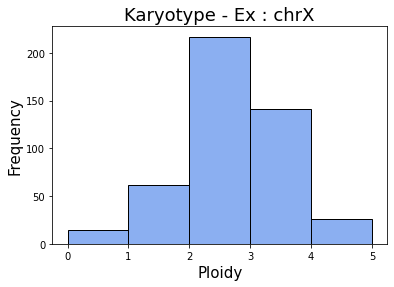

In [8]:
import seaborn as sns

karyo_new = [len(elem) for elem in res]

fig, axs = plt.subplots(figsize = (6, 4))
sns.histplot(karyo_new, color='cornflowerblue', binwidth=1);
axs.set_ylabel('Frequency', fontsize = 15)
axs.set_xlabel('Ploidy', fontsize = 15)
axs.set_title('Karyotype - {0} : {1}'.format(chosen_celltype, chosen_chrom), fontsize = 18)

- What does the spatial distribution of a cell with triploid `chosen_chrom = 'chrX'` look like?
    - We can also annotate the mouse __centromeres (▲)__ and mouse __telomeres (✖)__
    <br></br>
    - NB: `finalcellID` corresponds to a unique identifier the dataset authors used to delineate every cell imaged. `cell` correpsonds to the identifier of a given `replicate` in a particular `FOV`.

Text(-0.13, 1.03, '4-FOV5-cell30')

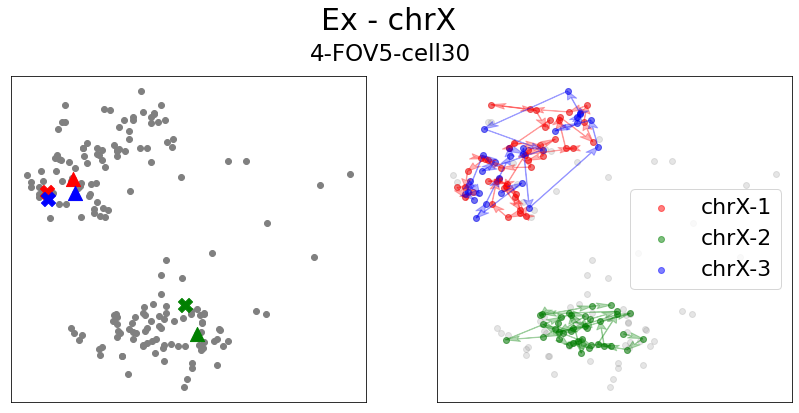

In [9]:
fig, axs = plt.subplots(1, 2, figsize =(14, 6), sharex = True)
colors = ['red', 'green', 'blue', 'purple']

# grab aligned loci
sel_pts = copy.deepcopy(res[378])

# grab cell metadata
sel_repl = sel_pts[0].replicate.iloc[0]
sel_fov = sel_pts[0].FOV.iloc[0]
sel_id = sel_pts[0].cell.iloc[0]
sel_cell = sel_pts[0].finalcellID.iloc[0]

## Background
# scatter plot all candidate points (including unaligned) as background
all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell) & 
                          (df_seqfish['chr'] == chosen_chrom)]

axs[0].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 1)
axs[1].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.2)

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

## Foreground
# scatter plot all aligned points
for i, elem in enumerate(sel_pts):

    for row_idx in range(elem.shape[0]):
        
        # skip if centromere or telomere
        if row_idx == 0:
            pass
        # otherwise plot
        else:
            # draw vectors guiding "tracing"
            x_curr, y_curr, z_curr = elem.x_hat.iloc[row_idx], elem.y_hat.iloc[row_idx], elem.z_hat.iloc[row_idx]
            x_prev, y_prev, z_prev = elem.x_hat.iloc[row_idx-1], elem.y_hat.iloc[row_idx-1], elem.z_hat.iloc[row_idx-1]

            axs[1].arrow(x_prev, y_prev, x_curr-x_prev, y_curr-y_prev, color = colors[i], 
                      alpha = 0.3, head_width = 1.7, width = 0.1, length_includes_head = True, overhang = .2)
    
    # scatter plot all selected coordinates
    axs[1].scatter(elem['x_hat'], elem['y_hat'], color = colors[i], label = 'chrX-'+str(i+1), alpha = 0.5)

    # demarcate centromere & telomere
    x_start, y_start, z_start = elem[['x_hat', 'y_hat', 'z_hat']].iloc[0]
    axs[0].scatter(x_start, y_start, marker='^', color=colors[i], s = 200)
    x_end, y_end, z_end = elem[['x_hat', 'y_hat', 'z_hat']].iloc[-1]
    axs[0].scatter(x_end, y_end, marker='X', color=colors[i], s = 200)

# annotate
plt.suptitle(t="{0} - {1}".format(chosen_celltype, chosen_chrom), fontsize = 30, x=0.5, y = 1.04)
plt.legend(prop={'size': 22})
plt.title("{0}-FOV{1}-cell{2}".format(sel_repl, sel_fov, sel_id), x=-.13, y=1.03, fontsize = 23)

- In the scope of the entire nucleus, we see `chosen_chrom == 'chrX'` tucked away in two spatial territories, with two resident fibers doubly occupying one territory.

Text(-0.13, 1.03, '4-FOV5-cell30')

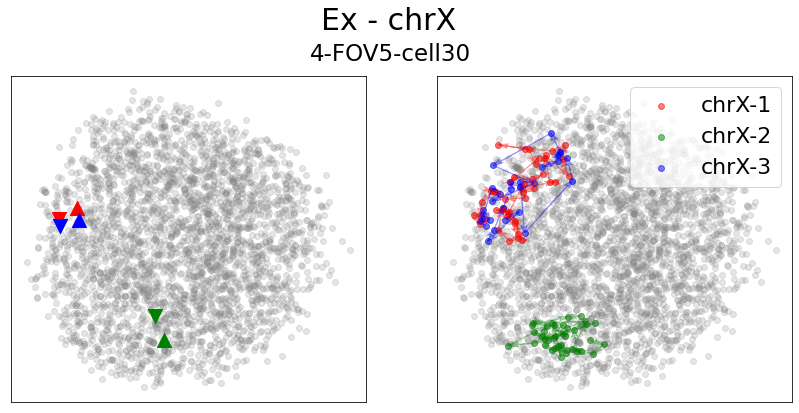

In [10]:
fig, axs = plt.subplots(1, 2, figsize =(14, 6), sharex = True)
colors = ['red', 'green', 'blue', 'purple']

# grab aligned loci 
sel_pts = copy.deepcopy(res[378])

# grab cell metadata
sel_repl = sel_pts[0].replicate.iloc[0]
sel_fov = sel_pts[0].FOV.iloc[0]
sel_id = sel_pts[0].cell.iloc[0]
sel_cell = sel_pts[0].finalcellID.iloc[0]

## Background
# scatter plot all candidate points of entire nucleus as background
all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell)]

axs[0].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.2)
axs[1].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.2)

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

## Foreground
# scatter plot all aligned points
for i, elem in enumerate(sel_pts):

    for row_idx in range(elem.shape[0]):
        # skip if centromere or telomere
        if row_idx == 0:
            pass
        # otherwise plot
        else:
            # draw vectors guiding "tracing"
            x_curr, y_curr, z_curr = elem.x_hat.iloc[row_idx], elem.y_hat.iloc[row_idx], elem.z_hat.iloc[row_idx]
            x_prev, y_prev, z_prev = elem.x_hat.iloc[row_idx-1], elem.y_hat.iloc[row_idx-1], elem.z_hat.iloc[row_idx-1]

            axs[1].arrow(x_prev, y_prev, x_curr-x_prev, y_curr-y_prev, color = colors[i], 
                      alpha = 0.3, head_width = 1.7, width = 0.1, length_includes_head = True, overhang = .2)
    
    # scatter plot all selected coordinates
    axs[1].scatter(elem['x_hat'], elem['y_hat'], color = colors[i], label = 'chrX-'+str(i+1), alpha = 0.5)

    # demarcate centromere & telomere
    x_start, y_start, z_start = elem[['x_hat', 'y_hat', 'z_hat']].iloc[0]
    axs[0].scatter(x_start, y_start, marker='^', color=colors[i], s = 200)
    x_end, y_end, z_end = elem[['x_hat', 'y_hat', 'z_hat']].iloc[-1]
    axs[0].scatter(x_end, y_end, marker='v', color=colors[i], s = 200)

# annotate
plt.suptitle(t="{0} - {1}".format(chosen_celltype, chosen_chrom), fontsize = 30, x=0.5, y = 1.04)
plt.legend(prop={'size': 22})
plt.title("{0}-FOV{1}-cell{2}".format(sel_repl, sel_fov, sel_id), x=-.13, y=1.03, fontsize = 23)

- We can examine the spatial organization of chromosomes with __density-based clustering__, stratified by ploidy.
    - This way, we can find just how many aneuploid neurons have __multiple occupant__ chromosome territories. 

In [11]:
from sklearn.cluster import DBSCAN

df_ktype = {'replicate': {},
            'FOV': {},
            'cell': {},
            'finalcellID': {},
            'celltype': {},
            'chr': {},
            'XistID': {},
            'ploidy': {},
            'nclusters':{},
            'data':{}}

# DBSCAN params
threshold = 10
eps = 11

# for every cell
for i, cell in enumerate(res):

    if len(cell) > 0:
        
        # merge chromatin fibers
        _df_cell = pd.concat(cell)
        
        # call cluster
        db = DBSCAN(eps=eps, min_samples=threshold).fit(_df_cell[['x_hat', 'y_hat', 'z_hat']])
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
       
        # save res
        df_ktype['replicate'][i] = _df_cell.iloc[0]['replicate']
        df_ktype['FOV'][i] = _df_cell.iloc[0]['FOV']
        df_ktype['cell'][i] = _df_cell.iloc[0]['cell']
        df_ktype['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
        df_ktype['celltype'][i] = _df_cell.iloc[0]['celltype']
        df_ktype['chr'][i] = _df_cell.iloc[0]['chr']
        df_ktype['XistID'][i] = False in np.isnan(_df_cell['XistID']).tolist()
        df_ktype['ploidy'][i] = len(cell)
        df_ktype['nclusters'][i] = n_clusters
        df_ktype['data'][i] = copy.deepcopy(cell)
        
df_ktype = pd.DataFrame(df_ktype)

Text(0.38, 1.1, 'Ex - chrX')

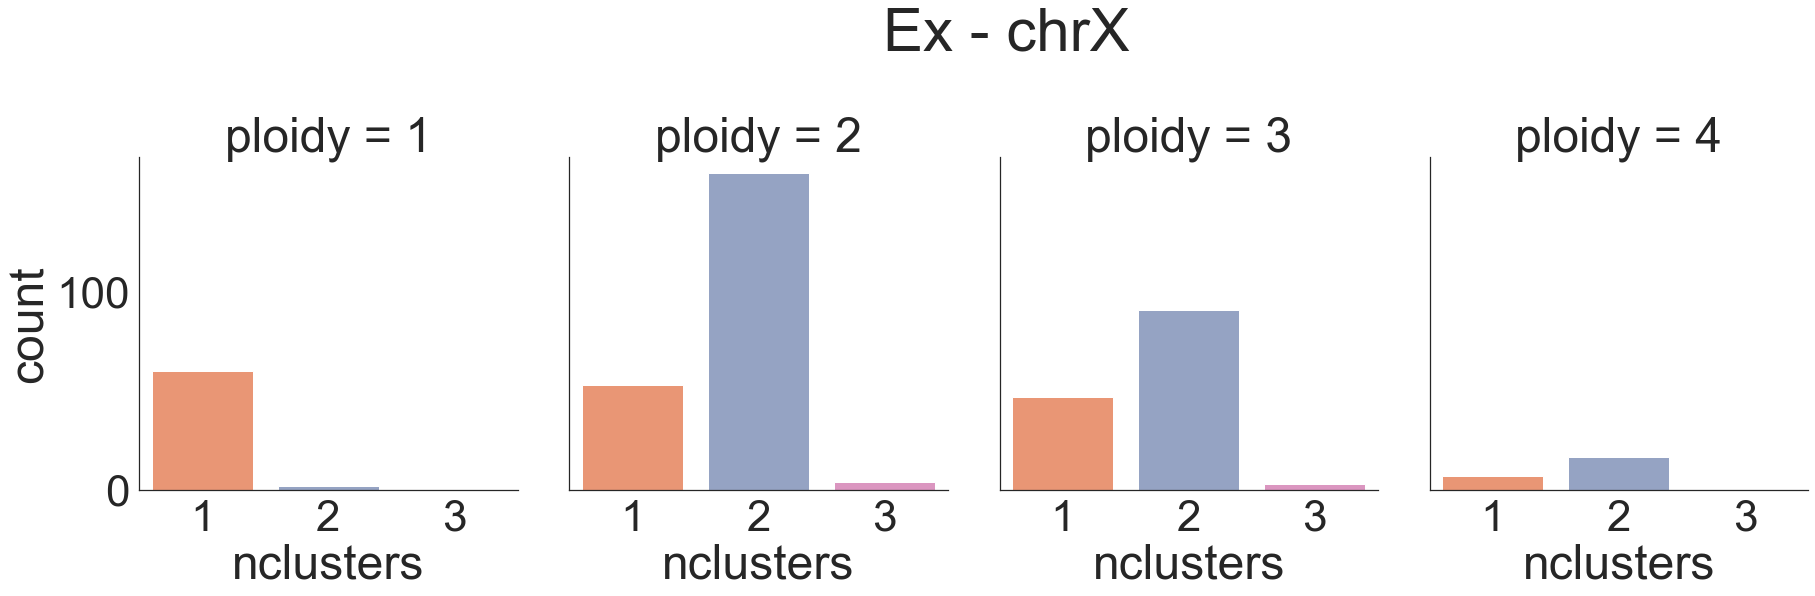

In [12]:
import seaborn as sns

palette ={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4:"C4", 5:"C5"}
sns.set_theme(style="white", font_scale = 4, palette = "Set2")

chosen_celltype = 'Ex'
chosen_chrom = 'chrX'

# plot frequency
g = sns.catplot(data = df_ktype[(df_ktype['chr'] == chosen_chrom) & 
                                (df_ktype['celltype'] == chosen_celltype) & 
                                (df_ktype['ploidy'] <= 4)],
                col = 'ploidy',
                x = 'nclusters', 
                kind = 'count',
                col_wrap = 6,
                height = 8,
                aspect = .8,
                legend_out = False,
                palette = palette)

# annotate
g.fig.suptitle("{0} - {1}".format(chosen_celltype, chosen_chrom), x=0.38, y = 1.1, fontsize = 60)

- It is also easy to inspect the median distance matrices of the active and inactive chrX.

In [13]:
import itertools
import warnings
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore", category=RuntimeWarning)

### Helper function ###
def find_replicating_pair(centroids):
    min_dist = np.inf
    best_pair = None
    for a, b in itertools.combinations([0, 1, 2], 2):
        _d = cdist([centroids[a]],[centroids[b]]).flatten()[0]
        if _d < min_dist:
            _d = min_dist
            best_pair = [a, b]
    not_paired = [elem for elem in [0, 1, 2] if elem not in best_pair]
    
    return best_pair[0], best_pair[1], not_paired[0]

########################

# grab gene list
chosen_celltype = 'Ex'
chosen_chrom = 'chrX'
gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta'].tolist()

# store inactive/active state
x_state = []
map_xist = {0:'Act', 1:'Inact'}

# calculate inter-sister, intra-sister distance matrices
df_sis = {'Act-Inter':[],
          'Act-Intra':[],
          'Inact-Inter':[],
          'Inact-Intra':[]}

# for every triploid cell
for cell in df_ktype[(df_ktype['ploidy'] == 3)]['data']:
    
    centroids = {}
    xist = {}
    
    # determine which chroms are replicated (paired sisters)
    for i, chrom in enumerate(cell):
        x, y, z = chrom[['x_hat', 'y_hat', 'z_hat']].mean().values
        centroids[i] = (x, y, z)
        try:
            xist_presence = chrom[['XistID']].mode().values.tolist()[0][0]
        except IndexError:
            xist_presence = np.nan
        xist[i] = xist_presence
        
    # figure out which is paired
    pair1, pair2, unpaired = find_replicating_pair(centroids)
    
    # check xist status
    if xist[pair1] == xist[pair2]:
        
        # save xist state
        x_state.append(map_xist[xist[pair1]])

        #### TRANS ####
        # calculate distance matrix
        intersis_dist1 = np.empty((len(gene_dist), len(gene_dist)))
        intersis_dist1[:] = np.nan

        row_hyb = cell[pair1].hyb
        col_hyb = cell[pair2].hyb
        
        trans_mat = cdist(cell[pair1][['x_hat', 'y_hat', 'z_hat']], cell[pair2][['x_hat', 'y_hat', 'z_hat']])

        # calculate trans median distance matrix
        for val, (row, col) in zip(trans_mat.flatten(), list(itertools.product(row_hyb, col_hyb))):
            intersis_dist1[row][col] = val

        # save trans distances
        df_sis[map_xist[xist[pair1]]+'-Inter'].append(intersis_dist1)

        #### CIS ####
        # caliculate cis median distance matrix
        intrasis_dist1 = plot.calc_med_dist_mat([cell[pair1]], len(gene_dist))
        intrasis_dist2 = plot.calc_med_dist_mat([cell[pair2]], len(gene_dist))
        intrasis_dist3 = plot.calc_med_dist_mat([cell[unpaired]], len(gene_dist))

        # save cis
        df_sis[map_xist[xist[pair1]]+'-Intra'].append(intrasis_dist1)
        df_sis[map_xist[xist[pair2]]+'-Intra'].append(intrasis_dist2)
        df_sis[map_xist[xist[unpaired]]+'-Intra'].append(intrasis_dist3)

- Here is how doubly occupied `chrX` territories stack up in terms of `Xist` RNA detection.

<AxesSubplot:xlabel='Replicated X-chr', ylabel='count'>

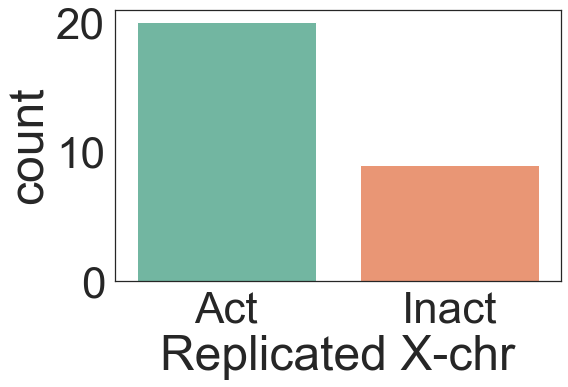

In [14]:
df_xiststat = pd.DataFrame(x_state, columns = ['Replicated X-chr'])

fig, axs = plt.subplots(figsize = (8, 5))
sns.countplot(x='Replicated X-chr', data=df_xiststat )

/tmp/ipykernel_1358618/2439110368.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic_r").copy()
  cmap.set_bad("gray")


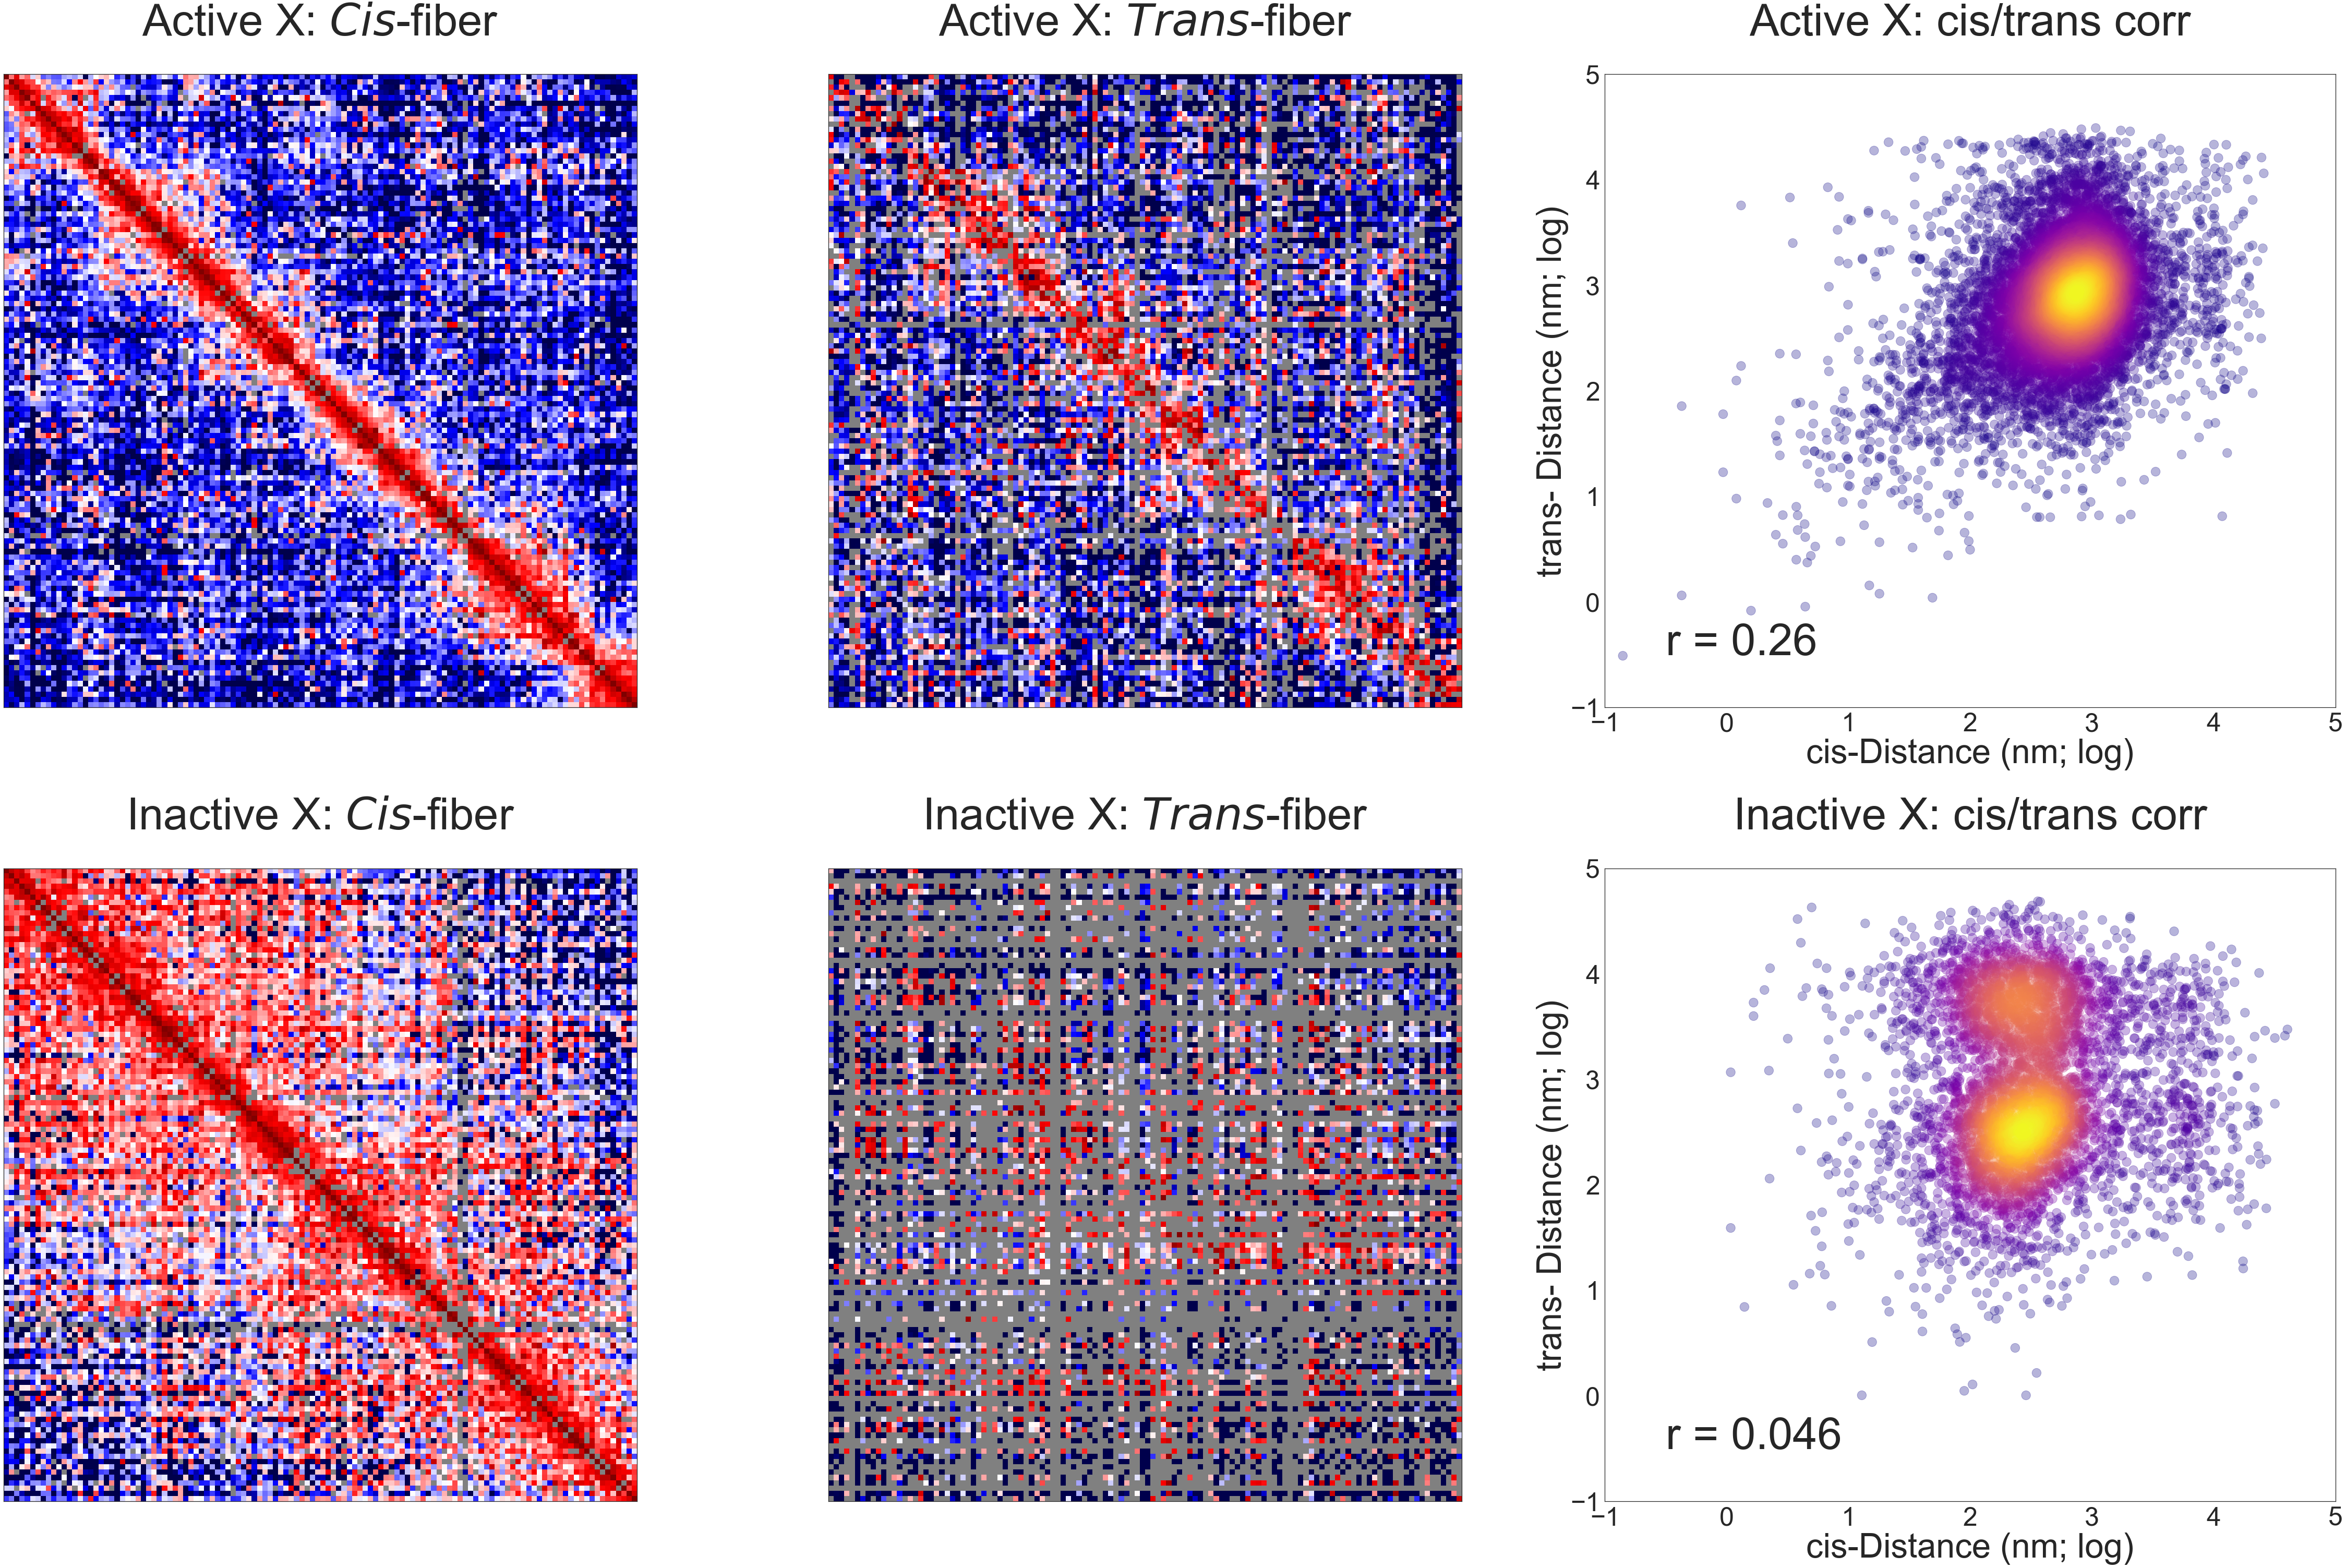

In [15]:
from scipy.signal import correlate2d
from scipy.stats import spearmanr, gaussian_kde

# calculate median distance
act_trans = np.nanmedian(df_sis['Act-Inter'], axis = 0)
act_cis = np.nanmedian(df_sis['Act-Intra'], axis = 0)
inact_trans = np.nanmedian(df_sis['Inact-Inter'], axis = 0)
inact_cis = np.nanmedian(df_sis['Inact-Intra'], axis = 0)

# plot
fig, axs = plt.subplots(2, 3, figsize = (65, 43))
cmap = plt.get_cmap("seismic_r")
cmap.set_bad("gray")

axs[0][0].imshow(act_cis, vmax = 25,  cmap = cmap)
axs[0][1].imshow(act_trans, vmax = 25, cmap = cmap)
axs[1][0].imshow(inact_cis, vmax = 25,  cmap = cmap)
axs[1][1].imshow(inact_trans, vmax = 25, cmap = cmap)
axs[0][0].set_title("Active X: $\it{Cis}$-fiber"  , fontsize = 85, pad = 75)
axs[0][1].set_title("Active X: $\it{Trans}$-fiber"  , fontsize = 85, pad = 75)
axs[1][0].set_title("Inactive X: $\it{Cis}$-fiber", fontsize = 85, pad = 75)
axs[1][1].set_title("Inactive X: $\it{Trans}$-fiber", fontsize = 85, pad = 75)

# KDE - active X
x1 = np.log(act_cis.flatten())
y1 = np.log(act_trans.flatten())
corr1, _ = spearmanr(act_cis.flatten(), act_trans.flatten(), nan_policy = 'omit')
drop_indeces = set(np.where(np.isinf(x1))[0]).union(np.where(np.isinf(y1))[0]) # remove inf
nan_indeces = set(np.where(np.isnan(x1))[0]).union(np.where(np.isnan(y1))[0]) # remove nans
drop_indeces = drop_indeces.union(nan_indeces)
x1 = [x1[i] for i in range(len(x1)) if i not in drop_indeces]
y1 = [y1[i] for i in range(len(y1)) if i not in drop_indeces]
xy1 = np.vstack([x1, y1])
z1 = gaussian_kde(xy1)(xy1)
density1 = z1.argsort()

im1 = axs[0][2].scatter([x1[i] for i in density1],
                        [y1[i] for i in density1],
                        c=[z1[i] for i in density1],
                        cmap = 'plasma',
                        alpha = 0.3,
                        s = 300)

# KDE - inactive X
x2 = np.log(inact_cis.flatten())
y2 = np.log(inact_trans.flatten())
corr2, _ = spearmanr(inact_cis.flatten(), inact_trans.flatten(), nan_policy = 'omit')
drop_indeces = set(np.where(np.isinf(x2))[0]).union(np.where(np.isinf(y2))[0]) # remove inf
nan_indeces = set(np.where(np.isnan(x2))[0]).union(np.where(np.isnan(y2))[0]) # remove nans
drop_indeces = drop_indeces.union(nan_indeces)
x2 = [x2[i] for i in range(len(x2)) if i not in drop_indeces]
y2 = [y2[i] for i in range(len(y2)) if i not in drop_indeces]
xy2 = np.vstack([x2, y2])
z2 = gaussian_kde(xy2)(xy2)
density2 = z2.argsort()

im2 = axs[1][2].scatter([x2[i] for i in density2],
                                    [y2[i] for i in density2],
                                    c=[z2[i] for i in density2],
                                    cmap = 'plasma',
                                    alpha = 0.3,
                                    s = 300,
                                   )

# annotate
axs[0][2].set_title("Active X: cis/trans corr", fontsize=85, pad = 75)
axs[0][2].patch.set_edgecolor('black')
axs[0][2].patch.set_linewidth('1')
axs[0][2].set_xlim(-1, 5)
axs[0][2].set_ylim(-1, 5)
axs[0][2].set_xlabel("cis-Distance (nm; log)", fontsize = 65, labelpad = 3)
axs[0][2].set_ylabel("trans- Distance (nm; log)", fontsize = 65, labelpad = 3)
axs[0][2].tick_params(axis='both', which='major', labelsize=50)
axs[0][2].annotate('r = {0:.2g}'.format(corr1), xy=(-.5, -.5), fontsize = 85)
axs[1][2].set_title("Inactive X: cis/trans corr", fontsize=85, pad = 75)
axs[1][2].patch.set_edgecolor('black')
axs[1][2].patch.set_linewidth('1')
axs[1][2].set_xlim(-1, 5)
axs[1][2].set_ylim(-1, 5)
axs[1][2].set_xlabel("cis-Distance (nm; log)", fontsize = 65, labelpad = 3)
axs[1][2].set_ylabel("trans- Distance (nm; log)", fontsize = 65, labelpad = 3)
axs[1][2].tick_params(axis='both', which='major', labelsize=50)
axs[1][2].annotate('r = {0:.2g}'.format(corr2), xy=(-.5, -.5), fontsize = 85)

# turn off ticks
axs[0][0].set_xticks([])
axs[0][1].set_yticks([])

axs[0][0].set_yticks([])
axs[0][1].set_xticks([])

axs[1][0].set_xticks([])
axs[1][1].set_yticks([])

axs[1][0].set_yticks([])
axs[1][1].set_xticks([])

plt.tight_layout()

- We can also compare the relationship between spatial distance and genomic distance, stratified by `Xist` status.
    - NB: The cell below may take some time to run.

(2.1, 4.2)

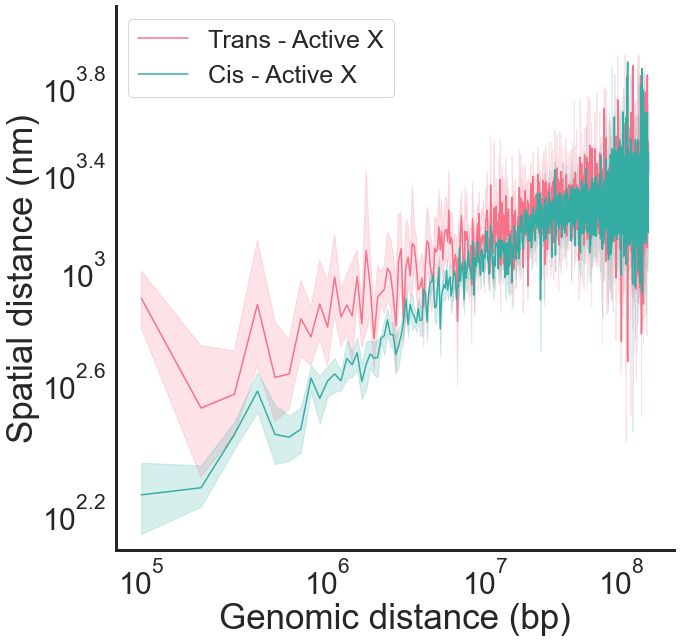

In [16]:
### TRANS dist stats ###
trans_hist = []
for mat in df_sis['Act-Inter']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        trans_hist.append([gene_delta, obs_dist])
        
### CIS dist stats ###
cis_hist = []
for mat in df_sis['Act-Intra']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        cis_hist.append([gene_delta, obs_dist])

### TRANS ###
# tabulate spatial distance given genomic distance
df_trans_dist = pd.DataFrame(trans_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_trans_dist.dropna(inplace = True)
df_trans_dist['Spatial distance'] = df_trans_dist['Spatial distance'] * 100
df_trans_dist['Category'] = ['Trans - Active X',] * df_trans_dist.shape[0]
df_trans_dist.reset_index(inplace = True)

### CIS ###
# tabulate spatial distance given genomic distance
df_cis_dist = pd.DataFrame(cis_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_cis_dist.dropna(inplace = True)
df_cis_dist['Spatial distance'] = df_cis_dist['Spatial distance'] * 100
df_cis_dist['Category'] = ['Cis - Active X',] * df_cis_dist.shape[0]
df_cis_dist.reset_index(inplace = True)

# Concatenate
df_cistrans = pd.concat([df_trans_dist, df_cis_dist])
df_cistrans.reset_index(inplace = True)

# bin data (per 10000 bp)
bin_size = 100000
bins = [bin_size * i for i in range(int(np.round(df_cistrans['Actual Genomic distance'].max() / bin_size)))]
bins[0] = -1
df_cistrans['binned'] = pd.cut(df_cistrans['Actual Genomic distance'], bins, include_lowest = True)
df_cistrans.dropna(inplace = True)
df_cistrans['Genomic distance'] = [elem.right for elem in df_cistrans['binned']]

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.set(xscale = "log", yscale = "log")
g = sns.lineplot(data = df_cistrans, x='Genomic distance',
           y='Spatial distance', hue = 'Category', 
           palette = "husl")

axs.set_xlabel("Genomic distance (bp)", fontsize = 35, labelpad =2 )
axs.set_ylabel("Spatial distance (nm)", fontsize = 35, labelpad = 2)
xlabels = ['$\\mathdefault{10^{5}}$',
           '$\\mathdefault{10^{6}}$',
           '$\\mathdefault{10^{7}}$',
           '$\\mathdefault{10^{8}}$']
ylabels = ['$\\mathdefault{10^{2.2}}$',
           '$\\mathdefault{10^{2.6}}$',
           '$\\mathdefault{10^{3}}$',
           '$\\mathdefault{10^{3.4}}$',
           '$\\mathdefault{10^{3.8}}$']

plt.xticks([5, 6, 7, 8], xlabels, fontsize = 30)
g.set_yticklabels([], minor = True)
plt.yticks([2.2, 2.6, 3, 3.4, 3.8], ylabels, fontsize = 30)
plt.legend(fontsize = 25)
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
plt.ylim(2.1, 4.2)

In [ ]:
### TRANS dist stats ###
trans_hist = []
for mat in df_sis['Inact-Inter']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        trans_hist.append([gene_delta, obs_dist])
        
### CIS dist stats ###
cis_hist = []
for mat in df_sis['Inact-Intra']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        cis_hist.append([gene_delta, obs_dist])
        
### TRANS ###
# tabulate spatial distance given genomic distance
df_trans_dist = pd.DataFrame(trans_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_trans_dist.dropna(inplace = True)
df_trans_dist['Spatial distance'] = df_trans_dist['Spatial distance'] * 100
df_trans_dist['Category'] = ['Trans - Inactive X',] * df_trans_dist.shape[0]
df_trans_dist.reset_index(inplace = True)

### CIS ###
# tabulate spatial distance given genomic distance
df_cis_dist = pd.DataFrame(cis_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_cis_dist.dropna(inplace = True)
df_cis_dist['Spatial distance'] = df_cis_dist['Spatial distance'] * 100
df_cis_dist['Category'] = ['Cis - Inactive X',] * df_cis_dist.shape[0]
df_cis_dist.reset_index(inplace = True)

# Concatenate
df_cistrans2 = pd.concat([df_trans_dist, df_cis_dist])
df_cistrans2.reset_index(inplace = True)

# bin data (per 10000 bp)
bin_size = 100000
bins = [bin_size * i for i in range(int(np.round(df_cistrans2['Actual Genomic distance'].max() / bin_size)))]
bins[0] = -1
df_cistrans2['binned'] = pd.cut(df_cistrans2['Actual Genomic distance'], bins, include_lowest = True)
df_cistrans2.dropna(inplace = True)
df_cistrans2['Genomic distance'] = [elem.right for elem in df_cistrans2['binned']]

# plot
fig, axs = plt.subplots(figsize = (10, 10))
axs.set(xscale = "log", yscale = "log")
g = sns.lineplot(data = df_cistrans2, x='Genomic distance',
           y='Spatial distance', hue = 'Category', 
           palette = "husl")

axs.set_xlabel("Genomic distance (bp)", fontsize = 35, labelpad =2 )
axs.set_ylabel("Spatial distance (nm)", fontsize = 35, labelpad = 2)
xlabels = ['$\\mathdefault{10^{5}}$',
 '$\\mathdefault{10^{6}}$',
 '$\\mathdefault{10^{7}}$',
 '$\\mathdefault{10^{8}}$']
ylabels = ['$\\mathdefault{10^{2.2}}$',
 '$\\mathdefault{10^{2.6}}$',
 '$\\mathdefault{10^{3}}$',
 '$\\mathdefault{10^{3.4}}$',
 '$\\mathdefault{10^{3.8}}$']

plt.xticks([5, 6, 7, 8], xlabels, fontsize = 30)
g.set_yticklabels([], minor = True)
plt.yticks([2.2, 2.6, 3, 3.4, 3.8], ylabels, fontsize = 30)
plt.legend(fontsize = 25)
axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
plt.ylim(2.1, 4.2)